<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; padding: 30px 30px 0px 30px;">Design an application for public health - Project 3</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;">
    <span style="width: 100%; text-align: center; font-size:20px; font-weight: bold; float: left;">| Cleaning notebook |</span>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <span style="width: 100%; text-align: center; font-size:26px; float: left;">Data Scientist course - OpenClassrooms</span>
</div>

<div class="alert alert-block alert-info">
    This <b>notebook</b> is optimized to <b>be used</b> with:
    <ul style="list-style-type: square;">
    <li>JupyterLab 3.0.14</li>
    <li>JupyterLab Theme: JupyterLab Dark</li>
    <li>Extension: @jupyter-widgets/jupyterlab-manager</li>
</ul>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries and functions</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.1. Libraries and functions</h3>
</div>

In [1]:
import os
import io
import gc
from math import prod
import time as time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

%matplotlib inline

<div class="alert alert-block alert-info">
Due to size of the dataset, it is necessary to show all columns to work on it
</div>

In [2]:
pd.set_option("display.max_columns", None) # show max of cols
pd.set_option("max_colwidth", None) # show full width of cols

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.2. Functions declaration</h3>
</div>

In [3]:
def df_analysis(df, name_df, columns, *args, **kwargs):
    """
    Analysis on the DataFrame.

    Parameters
    -----------------
        df (pandas.DataFrame): Dataset to analyze.
        name_df (str): Dataset name.
        columns (list): Dataframe keys in list format.
        
    *args, **kwargs:
    -----------------
        flag (str): Flag to show complete information about the dataset to analyse
                    "complete" shows all information about the dataset

    Returns:
    -----------------
        None. 
        Print the analysis on the Dataset. 
    """
    
    # Getting the variables
    flag = kwargs.get("flag", None)
    
    ORDERING_COMPLETE = [
        "name", "type", "records", "unique", "# NaN", "% NaN", "mean", "min", "25%", "50%", "75%", "max", "std"
    ]
    
    # Calculating the memory usage based on dataframe.info()
    buf = io.StringIO()
    df.info(buf=buf)
    memory_usage = buf.getvalue().split('\n')[-2]
    
    if df.empty:
        print("The", name_df, "dataset is empty. Please verify the file.")
    else:
        empty_cols = [col for col in df.columns if df[col].isna().all()] # identifying empty columns
        df_rows_duplicates = df[df.duplicated()] #identifying full duplicates rows
        
        # Creating a dataset based on Type object and records by columns
        type_cols = df.dtypes.apply(lambda x: x.name).to_dict() 
        df_resume = pd.DataFrame(list(type_cols.items()), columns = ["name", "type"])
        df_resume["records"] = list(df.count())
        df_resume["# NaN"] = list(df.isnull().sum())
        df_resume["% NaN"] = list(((df.isnull().sum() / len(df.index))*100).round(2))
        
        print("\nAnalysis of", name_df, "dataset")
        print("--------------------------------------------------------------------")
        print("- Dataset shape:                 ", df.shape[0], "rows and", df.shape[1], "columns")
        print("- Total of NaN values:           ", df.isna().sum().sum())
        print("- Percentage of NaN:             ", round((df.isna().sum().sum() / prod(df.shape)) * 100, 2), "%")
        print("- Total of full duplicates rows: ", df_rows_duplicates.shape[0])
        print("- Total of empty rows:           ", df.shape[0] - df.dropna(axis="rows", how="all").shape[0]) if df.dropna(axis="rows", how="all").shape[0] < df.shape[0] else \
                    print("- Total of empty rows:            0")
        print("- Total of empty columns:        ", len(empty_cols))
        print("  + The empty column is:         ", empty_cols) if len(empty_cols) == 1 else \
                    print("  + The empty column are:         ", empty_cols) if len(empty_cols) >= 1 else None
        
        print("\n- The key(s):", columns, "is not present multiple times in the dataframe.\n  It CAN be used as a primary key.") if df.size == df.drop_duplicates(columns).size else \
            print("\n- The key(s):", columns, "is present multiple times in the dataframe.\n  It CANNOT be used as a primary key.")
        
        pd.set_option("display.max_rows", None) # show full of showing rows
        pd.set_option("display.max_columns", None) # show full of showing cols
        pd.set_option("max_colwidth", None) # show full width of showing cols
        
        if flag is None or flag != "complete":
            print("\n- Type object and records by columns   (",memory_usage,")")
            print("--------------------------------------------------------------------")
        elif flag == "complete":
            df_resume["unique"] = list(df.nunique())
            df_desc = pd.DataFrame(df.describe().T).reset_index()
            df_desc = df_desc.rename(columns={"index": "name"})
            df_resume = df_resume.merge(right=df_desc[["name", "mean", "min", "25%", "50%", "75%", "max", "std"]], on="name", how="left")
            df_resume = df_resume[ORDERING_COMPLETE]
            print("\n- Type object and records by columns                                                                        (",memory_usage,")")
            print("---------------------------------------------------------------------------------------------------------------------------------------")
        
        display(df_resume.sort_values("records", ascending=False))
        
        pd.reset_option("display.max_rows") # reset max of showing rows
        pd.reset_option("display.max_columns") # reset max of showing cols
        pd.reset_option("display.max_colwidth") # reset width of showing cols
        
        # deleting dataframe to free memory
        if flag == "complete":
            del [[df_resume, df_desc]]
            gc.collect()
            df_resume, df_desc = (pd.DataFrame() for i in range(2))
        else:
            del df_resume
            gc.collect()
            df_resume = pd.DataFrame()
                        
            
def plot_missing_values(df, numbers_col):
    """
    Plotting missing values

    Parameters
    -----------------
        df (pandas.DataFrame): Dataset to analyze.
        numbers_col (int): Number of columns to show in each image.
        
    Returns:
    -----------------
        None. 
        Plotting the missing values
    """
    
    first_col = 0
    
    
    if df.shape[1] // numbers_col != 0:
    
        for i in range (1, df.shape[1] // numbers_col + 1):

            if i == df.shape[1] // numbers_col:
                last_col = None
            else:
                last_col = i * numbers_col

            with plt.style.context("default"):
                fig, axs = plt.subplots(2,1)
                msno.matrix(df.iloc[:, first_col:last_col], sparkline=False, fontsize=11, ax=axs[0])
                msno.bar(df.iloc[:, first_col:last_col], ax=axs[1], fontsize=11)            

                for ax in axs:
                    labels = [item.get_text() for item in ax.get_xticklabels()]
                    short_labels = [s[:8] + "..." + s[-8:] if len(s) > 16 else s for s in labels]
                    ax.axes.set_xticklabels(short_labels)

            fig.set_size_inches(12,8)
            [ax.grid() for ax in axs.flatten()];
            [sns.despine(ax=ax, right=False, left=False, top=False, bottom=False) for ax in axs.flatten()];

            plt.subplots_adjust(hspace=0.3)
            plt.tight_layout(rect=[0, 0.05, 1, 0.92])
            fig.suptitle("Missing data overview\n(part " + str(i) + "/" + str(df.shape[1] // numbers_col) + ")", fontweight="bold", fontsize=14)       

            plt.show()

            if i == data.shape[1] // 30:
                # deleting dataframe to free memory
                del [df]
                gc.collect()
                df = pd.DataFrame()

                break            
            else:
                first_col = last_col + 1
    
    else:
        
         with plt.style.context("default"):
            
            fig, axs = plt.subplots(2,1)
            msno.matrix(df.iloc[:, 0:], sparkline=False, fontsize=11, ax=axs[0])
            msno.bar(df.iloc[:, 0:], ax=axs[1], fontsize=11)            

            for ax in axs:
                labels = [item.get_text() for item in ax.get_xticklabels()]
                short_labels = [s[:7] + "..." + s[-7:] if len(s) > 14 else s for s in labels]
                ax.axes.set_xticklabels(short_labels)

            fig.set_size_inches(12,8)
            [ax.grid() for ax in axs.flatten()];
            [sns.despine(ax=ax, right=False, left=False, top=False, bottom=False) for ax in axs.flatten()];

            plt.subplots_adjust(hspace=0.3)
            plt.tight_layout(rect=[0, 0.05, 1, 0.92])
            fig.suptitle("Missing data overview", fontweight="bold", fontsize=14)       

            plt.show()
            
            del [df]
            gc.collect()
            df = pd.DataFrame()
        

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Importing files</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.1. Importing and preparing files</h3>
</div>

<div class="alert alert-block alert-info">
Reading data in <b>chunks of 1 million rows</b> at a time
</div>

In [4]:
start = time.time()
chunk = pd.read_csv("datasets/en.openfoodfacts.org.products.csv", chunksize=1000000, sep="\t", encoding="UTF-8")
data = pd.concat(chunk)
end = time.time()
print("Read csv with chunks: ",(end-start),"sec")

C:\Users\Samir\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (0,8,13,27,28,29,31,47,52,55,64) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Samir\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (0,8,13,29,31,47,52,64,81,84) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Read csv with chunks:  73.77009510993958 sec


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.2. Missing data overview</h3>
</div>

<div class="alert alert-block alert-info">
Making <b>the initial analysis</b>
</div>

<div class="alert alert-block alert-warning">
    Based on the function <b>df_analysis</b> we got the following facts:
    <ul style="list-style-type: square;">
        <li>Almost <b>80%</b> of the data present in data set are <b>missing values</b></li>
        <li>There are <b>5 empty columns</b> that we can delete</li>
        <li>There is a lot of <b>memory usage</b> with this dataset</li>
    </ul>
</div>

In [5]:
df_analysis(data, "data", "code")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  1760097 rows and 186 columns
- Total of NaN values:            260478039
- Percentage of NaN:              79.56 %
- Total of full duplicates rows:  1
- Total of empty rows:            0
- Total of empty columns:         5
  + The empty column are:          ['cities', 'allergens_en', 'no_nutriments', 'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil']

- The key(s): code is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns   ( memory usage: 2.4+ GB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,code,object,1760097,0,0.00
6,last_modified_datetime,object,1760097,0,0.00
63,states_en,object,1760097,0,0.00
62,states_tags,object,1760097,0,0.00
61,states,object,1760097,0,0.00
1,url,object,1760097,0,0.00
5,last_modified_t,int64,1760097,0,0.00
4,created_datetime,object,1760097,0,0.00
3,created_t,int64,1760097,0,0.00
2,creator,object,1760093,4,0.00


<div class="alert alert-block alert-info">
Plotting missing values with <b>missingno</b>
</div>

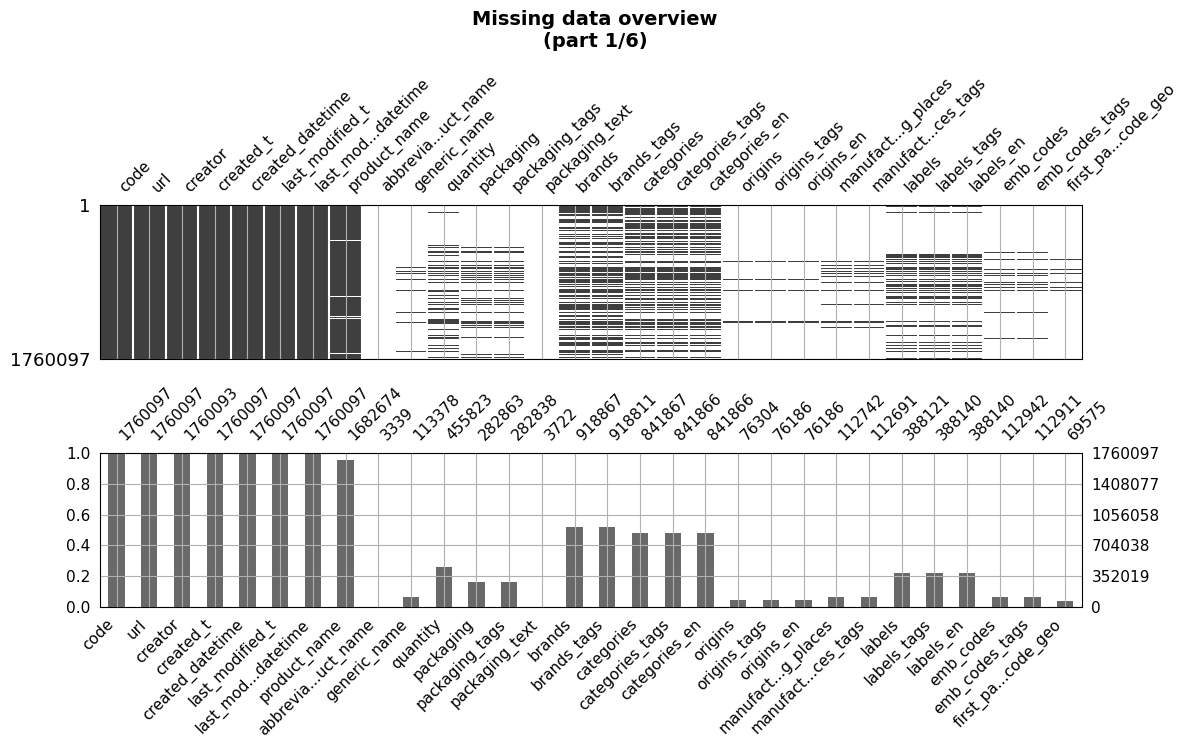

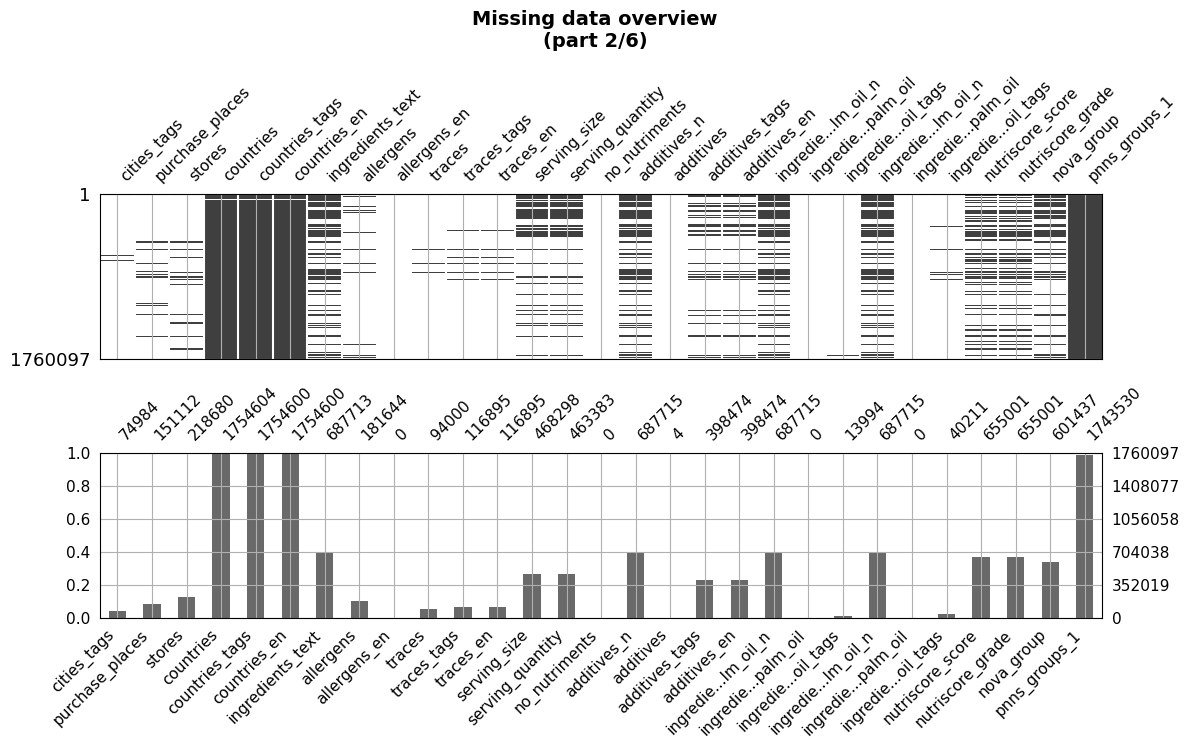

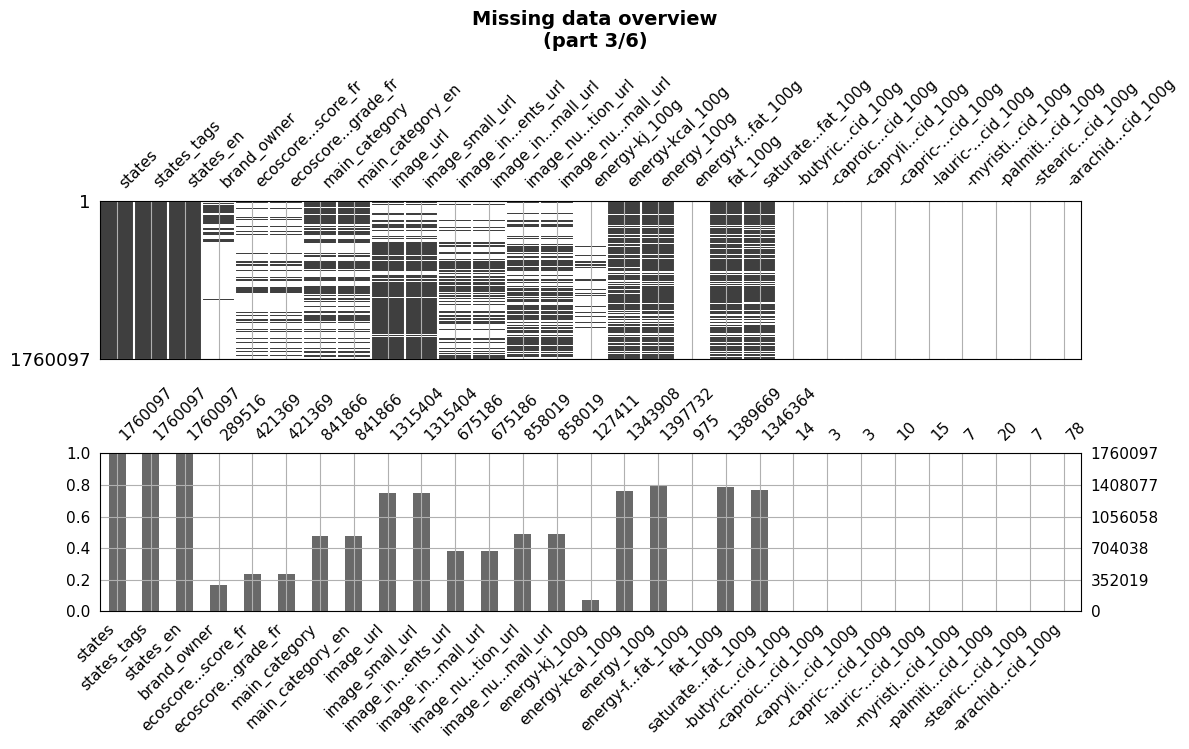

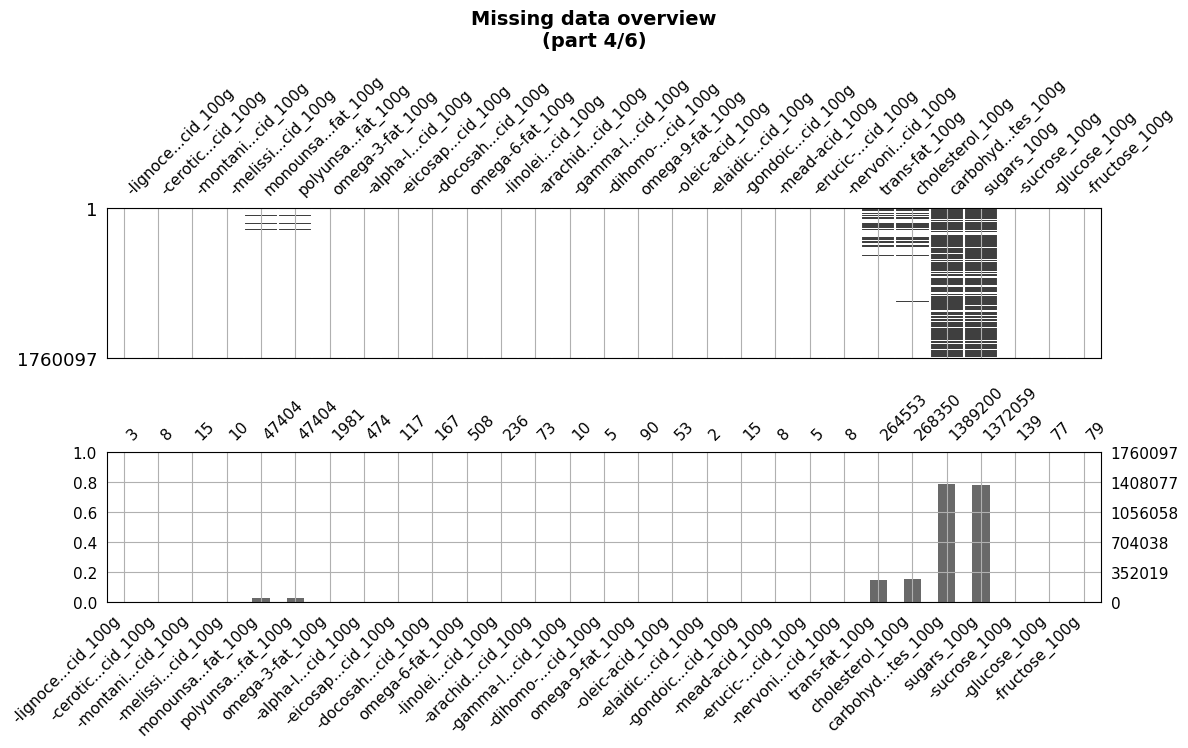

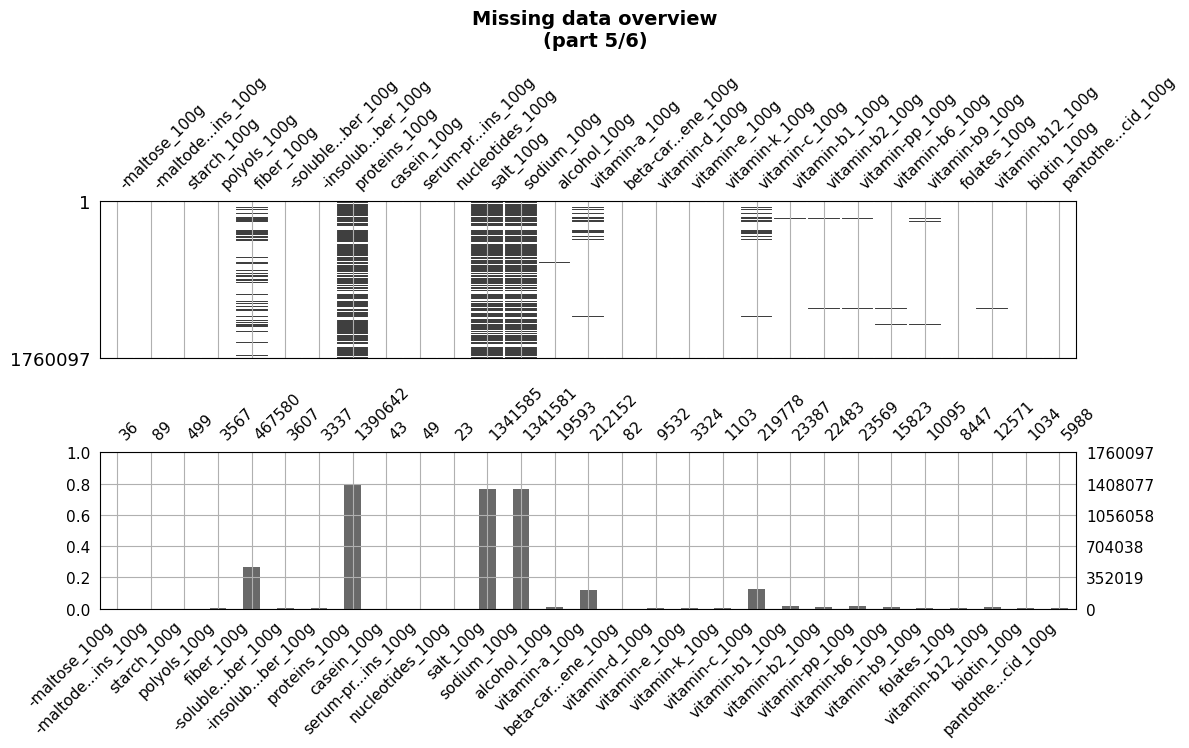

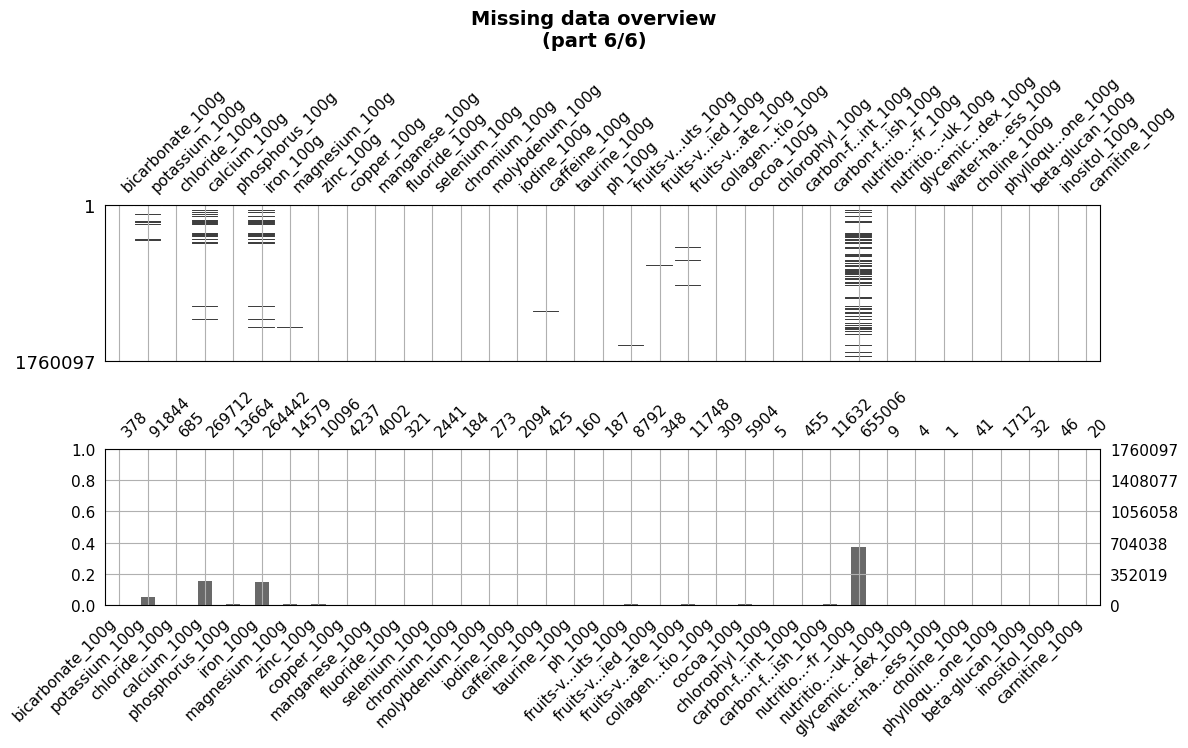

In [6]:
plot_missing_values(data, 30)

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Cleaning dataset</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.1. Deleting NaN columns and rows, and duplicated rows</h3>
</div>

In [7]:
data = data.dropna(axis="columns", how="all").dropna(axis="rows", how="all")

In [8]:
data = data.drop_duplicates()

In [9]:
df_analysis(data, "data", "code")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  1760096 rows and 181 columns
- Total of NaN values:            251677390
- Percentage of NaN:              79.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0

- The key(s): code is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns   ( memory usage: 2.4+ GB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,code,object,1760096,0,0.00
58,states_en,object,1760096,0,0.00
3,created_t,int64,1760096,0,0.00
4,created_datetime,object,1760096,0,0.00
5,last_modified_t,int64,1760096,0,0.00
6,last_modified_datetime,object,1760096,0,0.00
57,states_tags,object,1760096,0,0.00
1,url,object,1760096,0,0.00
56,states,object,1760096,0,0.00
2,creator,object,1760092,4,0.00


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.2. Fixing the columns types</h3>
</div>

<div class="alert alert-block alert-warning">
There are some columns with column type wrong. We can see this information based on:
<ul style="list-style-type: square;">
    <li>Open Food Facts data-fileds: <b>https://world.openfoodfacts.org/data/data-fields.txt</b></li>
    <li>At the momento to <b>import the *.csv</b></li>
    <li>As a result of the function <b>df_initial_analysis</b></li>
</ul>

Due to that, we are going to proceed to fix them. 
</div>
<div class="alert alert-block alert-info">
<b>Fixing column types float64</b><br>
Based on Open Food Facts data-fileds: <b>https://world.openfoodfacts.org/data/data-fields.txt</b>, we know the following
<ul style="list-style-type: square;">
    <li>fields that end with <b>_100g</b> correspond to <b>the amount of a nutriment</b> (in g, or kJ for energy) for <b>100 g</b> or <b>100 ml</b> of product</li>
    <li>fields that end with <b>_serving</b> correspond to <b>the amount of a nutriment</b> (in g, or kJ for energy) for <b>1</b> serving of the product</li>
</ul>

Finally, we are going to make the <b>downcast</b> from <b>float64</b> to <b>float32</b> 
</div>

In [10]:
for col in data.columns:
    if (col.endswith("_100g") or col.endswith("_serving")) and data[col].dtypes != "float64":
        print("Column to update the column type:", col, data[col].dtypes)
        data[col] = data[col].astype("float64")

Column to update the column type: -butyric-acid_100g object
Column to update the column type: -capric-acid_100g object


In [11]:
for col in data.columns:
    if data[col].dtypes == "float64":
        data[col] = data[col].astype("float32")

<div class="alert alert-block alert-info">
<b>Fixing column types datetime</b><br>
Based on Open Food Facts data-fileds: <b>https://world.openfoodfacts.org/data/data-fields.txt</b>, we know the following:
<ul style="list-style-type: square;">
    <li>fields that end with <b>_t</b> are dates in <b>the UNIX timestamp format</b> (number of seconds since Jan 1st 1970)</b></li>
    <li>fields that end with <b>_datetime</b> are dates in <b>the iso8601 format: yyyy-mm-ddThh:mn:ssZ</b></li>
</ul>

In this case, both group of columns have the same amount of data. Due to that, we will only keep the columns ended by <b>_datetime</b>
</div>

In [12]:
for col in data.columns:
    if col.endswith("_datetime") and data[col].dtypes != "datetime64":
        print("Column to update the column type:", col, data[col].dtypes)
        data[col] = data[col].astype("datetime64")

Column to update the column type: created_datetime object
Column to update the column type: last_modified_datetime object


In [13]:
for col in data.columns:
    if col.endswith("_t"):
        print("Column to delete:", col, data[col].dtypes)
        data = data.drop(col, axis=1)  

Column to delete: created_t int64
Column to delete: last_modified_t int64


<div class="alert alert-block alert-info">
Checking the usage of memory
</div>

In [14]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1760096 entries, 0 to 1760096
Columns: 179 entries, code to carnitine_100g
dtypes: datetime64[ns](2), float32(118), object(59)
memory usage: 8.1 GB


<div class="alert alert-block alert-info">
If the number of unique values in a specific column is less than the half numbers of rows in the same column,<br>
we are going to change the type from <b>object</b> to <b>category</b> to improve the usage of memory
</div>

In [15]:
for col in data.columns:
    if data[col].dtypes == "object":
        if len(data[col].unique()) / len(data[col]) < 0.5:
            data[col] = data[col].astype("category")
        else:
            data[col] = data[col].astype("object")

<div class="alert alert-block alert-info">
Checking the usage of memory
</div>

In [16]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1760096 entries, 0 to 1760096
Columns: 179 entries, code to carnitine_100g
dtypes: category(54), datetime64[ns](2), float32(118), object(5)
memory usage: 2.8 GB


In [17]:
df_analysis(data, "data", "code")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  1760096 rows and 179 columns
- Total of NaN values:            251677390
- Percentage of NaN:              79.88 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0

- The key(s): code is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns   ( memory usage: 1.3+ GB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,code,object,1760096,0,0.00
54,states,category,1760096,0,0.00
56,states_en,category,1760096,0,0.00
55,states_tags,category,1760096,0,0.00
1,url,object,1760096,0,0.00
4,last_modified_datetime,datetime64[ns],1760096,0,0.00
3,created_datetime,datetime64[ns],1760096,0,0.00
2,creator,category,1760092,4,0.00
53,pnns_groups_2,category,1759729,367,0.02
31,countries,category,1754603,5493,0.31


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Filtering information</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.1. Filtering information by country France</h3>
</div>

<div class="alert alert-block alert-info">
<b>Countries where the product is sold</b><br>
Based on Open Food Facts data-fileds: <b>https://world.openfoodfacts.org/data/data-fields.txt</b>, we know the following
<ul style="list-style-type: square;">
    <li> There are three fields about countries where the product is sold</li>
        <ul style="list-style-type: disc;">
            <li>countries</li>
            <li>countries_en</li>
            <li>countries_tags</li>
        </ul>
</ul>

After analyzing the columns, we have decided to used the columns called <b>countries</b>.<br>
We are going to filter considering only France and its overseas department
</div>

In [18]:
FILTERING_BY_FRANCE = [
    "France", "fr", "Francia", "French", "Frankreich", "Nouvelle-Calédonie", "Martinique", "Guadeloupe", "Polynésie Française", "Mayotte"
]

<div class="alert alert-block alert-success">
At this point, we have reduced the amount of data in the dataset filtering by country France
</div>

In [19]:
data = pd.DataFrame(data[data["countries"].str.contains("|".join(FILTERING_BY_FRANCE), case = False, na=False).any(level=0)])

In [20]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798009 entries, 0 to 1760096
Columns: 179 entries, code to carnitine_100g
dtypes: category(54), datetime64[ns](2), float32(118), object(5)
memory usage: 1.8 GB


In [21]:
df_analysis(data, "data", "code")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  798009 rows and 179 columns
- Total of NaN values:            114437088
- Percentage of NaN:              80.11 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         4
  + The empty column are:          ['-lignoceric-acid_100g', '-dihomo-gamma-linolenic-acid_100g', '-elaidic-acid_100g', 'water-hardness_100g']

- The key(s): code is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns   ( memory usage: 710.3+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,code,object,798009,0,0.00
54,states,category,798009,0,0.00
3,created_datetime,datetime64[ns],798009,0,0.00
4,last_modified_datetime,datetime64[ns],798009,0,0.00
55,states_tags,category,798009,0,0.00
56,states_en,category,798009,0,0.00
1,url,object,798009,0,0.00
33,countries_en,category,798009,0,0.00
32,countries_tags,category,798009,0,0.00
31,countries,category,798009,0,0.00


In [22]:
data = data.dropna(axis="columns", how="all").dropna(axis="rows", how="all")

<div class="alert alert-block alert-info">
Exectuting the <b>describe()</b> function on the dataframe
</div>

In [23]:
pd.set_option("display.max_columns", None) # show full of showing cols
data.describe()

C:\Users\Samir\anaconda3\lib\site-packages\numpy\lib\function_base.py:3964: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t>=0.5)


,serving_quantity,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,nova_group,ecoscore_score_fr,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,-soluble-fiber_100g,-insoluble-fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
count,79357.000000,243846.000000,243846.000000,243846.000000,278981.000000,204621.000000,255512.000000,7.190500e+04,5.955160e+05,6.230900e+05,131.000000,617113.000000,620073.000000,3.000000e+00,2.000000,1.0,2.000,7.000000,1.00,4.000000e+00,2.000000,29.000000,12.000000,1.0,2.000000,4.000000e+00,3134.000000,3157.000000,1348.000000,340.000000,63.000000,99.000000,292.000000,203.000000,31.000000,4.000000,4.900000e+01,21.000000,3.000000,1.00000,2.000000e+00,2.000000e+00,3647.000000,3677.000000,617058.00000,619338.000000,24.000000,2.900000e+01,53.000000,228.000000,13.000000,57.000000,290.000000,765.000000,139641.000000,188.000000,181.000000,618992.000000,39.000000,31.000000,15.000000,603563.000000,603562.000000,9209.000000,3396.000000,49.000000,1.611000e+03,1785.000000,178.000000,4833.000000,2188.000000,1798.000000,1786.000000,1978.000000,1462.000000,238.000000,1.597000e+03,403.000000,928.000000,77.000000,231.000000,2683.000000,424.000000,8408.000000,1618.000000,5291.000000,2472.000000,930.000000,372.000000,392.000000,1.970000e+02,281.000000,47.000000,45.000000,343.000000,111.000000,57.000000,130.000000,6300.000000,307.000000,10488.000000,296.000000,4409.000000,3.000000,319.000000,11632.000000,278984.000000,5.000000,4.000000,31.000000,29.000000,18.000000,24.000000,14.000000
mean,118.894379,1.615872,0.048883,0.114092,9.532871,3.411380,48.509956,1.103681e+03,2.832928e+02,1.178383e+03,432.374054,14.309522,5.446947,2.582482e+20,24.014999,97.0,inf,27.353390,0.12,1.532558e+00,2.100000,3.947972,1.257143,0.0,31.000000,5.264027e-01,20.867825,9.733136,3.332329,2.166044,2.646438,0.844953,17.107796,3.695531,0.532343,0.823750,4.233134e+01,30.364353,11.001293,0.00057,1.550030e-02,7.000000e+00,0.035219,0.048734,27.36570,13.761168,17.400002,1.302966e+01,29.481323,8.522764,8.162395,5.817037,32.900581,44.481972,3.022539,2.005319,4.316906,9.138214,4.165897,4.316871,0.796109,1.310894,0.524460,6.043071,0.546040,0.869422,1.870809e-01,0.187911,0.001249,0.229725,0.900481,0.05

In [24]:
pd.reset_option("display.max_columns") # reset max of showing cols

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">4. Nutri-Score fields</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.1. Idenfiying Nutri-Score fields</h3>
</div>

<div class="alert alert-block alert-info">
Based on <b>Santé publique France</b> we can get the fiedls to calculate the <b>Nutri-Score</b><br><br>
You can see the information in details in the link below<br>
<b>https://www.santepubliquefrance.fr/determinants-de-sante/nutrition-et-activite-physique/articles/nutri-score</b><br><br>
    
<b>Nutri-Score fields</b>
<ul style="list-style-type: square;">
    <li>Energetic value</li>
    <li>Fat</li>
    <li>Saturated fat</li>
    <li>Sugar</li>
    <li>Protein</li>
    <li>Salt / Sodium</li>
    <li>Fibers</li>
    <li>Fruits, vegetables, legumes, nuts, rapeseed, walnut and olive oils</li>
</ul>
</div>

In [25]:
pd.set_option("display.max_columns", None)
data.head(5)

,code,url,creator,created_datetime,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,traces,traces_tags,traces_en,serving_size,serving_quantity,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,brand_owner,ecoscore_score_fr,ecoscore_grade_fr,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,-soluble-fiber_100g,-insoluble-fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,2018-06-15 10:38:00,2019-06-25 11:55:18,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",NaN,NaN,NaN,NaN,NaN,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,NaN,NaN,NaN,375.0,1569.0,NaN,7.0,3.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.099998,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.8,NaN,NaN,NaN,1.40,0.560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [26]:
pd.reset_option("display.max_columns")

<div class="alert alert-block alert-info">
After analyzing the columns vs the <b>Nutri-Score</b>, we can identify the following fields
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Field</th>
        <th style="font-weight: bold;">Description</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
 	<tr>
		<td align="left">Energetic value</td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">
            energy-kj_100g<br>
            energy-kcal_100g<br>
            energy_100g</td>
        <td align="left">
            The fields energy-kj_100g and energy_100g seem to be the same value.<br>
            Consider the measure units to work with the values.
        </td>
 	</tr>
 	<tr>
		<td align="left">Fat</td>
        <td align="center">Nutri-score</td>
		<td align="center">No</td>
        <td align="left">fat_100g</td>
        <td align="left"></td>
 	</tr>
 	<tr>
		<td align="left">Saturated fat</td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">saturated-fat_100g</td>
        <td align="left"></td>
 	</tr>
 	<tr>
		<td align="left">Sugar</td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">sugars_100g</td>
        <td align="left"></td>
 	</tr>
  	<tr>
		<td align="left">Protein</td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">proteins_100g</td>
        <td align="left"></td>
 	</tr>
  	<tr>
		<td align="left">Salt / Sodium</td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">
            salt_100g<br>
            sodium_100g</td>
        <td align="left">Consider the measure units to work with the values.</td>
 	</tr>
  	<tr>
		<td align="left">Fibers</td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">fiber_100g</td>
        <td align="left"></td>
 	</tr>
  	<tr>
		<td align="left">
            Fruits, vegetables, legumes,<br>
            nuts, rapeseed, walnut<br> and olive oils
        </td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">
            fruits-vegetables-nuts_100g<br>
            fruits-vegetables-nuts-estimate_100g
        </td>
        <td align="left">
            It is necessary to analyze these fields more in details. 
        </td>
 	</tr>
    <tr>
		<td align="left">Code</td>
        <td align="center">App/Basic field</td>
		<td align="center">Yes</td>
        <td align="left">code</td>
        <td align="left"></td>
 	</tr>
    <tr>
		<td align="left">Last modified</td>
        <td align="center">App/Basic field</td>
		<td align="center">Yes</td>
        <td align="left">last_modified_datetime</td>
        <td align="left"></td>
 	</tr>
    <tr>
		<td align="left">Product name</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">product_name</td>
        <td align="left"></td>
 	</tr>
    <tr>
		<td align="left">Category</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">
            categories<br>
            main_category<br>
            main_category_en<br>
            categories_tags<br>
            categories_en
        </td>
        <td align="left">It is necessary to analyze these fields more in details.</td>
 	</tr>
    <tr>
		<td align="left">Image</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">image_url</td>
        <td align="left"></td>
 	</tr>
</table>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.2. Analyzing  the Nutri-Score fields</h3>
</div>

<div class="alert alert-block alert-info">
    Let's create a dataframe with interesting fields of <b>Nutri-Score</b> and the <b>application idea</b>
</div>

In [27]:
BASIC_FIELDS = [
    "code", "last_modified_datetime", "product_name", "categories", "main_category",
    "main_category_en", "categories_tags", "categories_en", "image_url"
]

In [28]:
NUTRI_SCORE_FIELDS = [
    "energy-kj_100g", "energy-kcal_100g", "energy_100g", "fat_100g", "saturated-fat_100g", 
    "sugars_100g", "proteins_100g", "salt_100g", "sodium_100g", "fiber_100g", 
    "fruits-vegetables-nuts_100g", "fruits-vegetables-nuts-estimate_100g"
]

In [29]:
df_nutri_score = data[BASIC_FIELDS + NUTRI_SCORE_FIELDS].copy(deep=True)

<div class="alert alert-block alert-info">
Making <b>the initial analysis</b>
</div>

In [30]:
df_analysis(df_nutri_score, "df_nutri_score", "code", flag="complete")


Analysis of df_nutri_score dataset
--------------------------------------------------------------------
- Dataset shape:                  798009 rows and 21 columns
- Total of NaN values:            6740162
- Percentage of NaN:              40.22 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0

- The key(s): code is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns                                                                        ( memory usage: 89.3+ MB )
---------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,798009,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,last_modified_datetime,datetime64[ns],798009,696994,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_name,object,775020,528750,22989,2.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,image_url,object,720228,720158,77781,9.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,energy_100g,float32,623090,4545,174919,21.92,1178.382935,0.0,464.000,1100.000000,1674.000000,12200000.0,15538.601562
13,saturated-fat_100g,float32,620073,3684,177936,22.30,5.446947,0.0,0.200,2.000000,8.000000,21900.0,29.066158
14,sugars_100g,float32,619338,5341,178671,22.39,13.761168,-1.0,0.600,3.500000,19.985256,6880.0,21.925907
15,proteins_100g,float32,618992,4101,179017,22.43,9.138214,0.0,1.500,6.200000,12.900000,173000.0,220.102295
12,fat_100g,float32,617113,4941,180896,22.67,14.309522,0.0,1.000,8.000000,22.000000,91200.0,117.423164
16,salt_100g,float32,603563,6284,194446,24.37,1.310894,0.0,0.060,0.510000,1.300000,25000.0,32.950630


<div class="alert alert-block alert-info">
    Processing the duplicates
</div>

In [31]:
df_nutri_score.drop_duplicates(inplace=True)

In [32]:
df_nutri_score[df_nutri_score["categories"].notnull()].head(5)

,code,last_modified_datetime,product_name,categories,main_category,main_category_en,categories_tags,categories_en,image_url,energy-kj_100g,...,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fiber_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g
4,0000000000100,2015-10-12 14:13:32,moutarde au moût de raisin,"Epicerie, Condiments, Sauces, Moutardes",en:mustards,Mustards,"en:groceries,en:condiments,en:sauces,en:mustards","Groceries,Condiments,Sauces,Mustards",https://static.openfoodfacts.org/images/produc...,936.0,...,936.0,8.2,2.2,22.0,5.1,4.60,1.840,0.0,NaN,NaN
5,00000000001111111111,2019-06-08 18:56:13,Sfiudwx,Xsf,fr:xsf,fr:xsf,fr:xsf,fr:xsf,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,000000000088,2019-12-26 11:06:50,Pate d'amende,Pâte d'amende,fr:pate-d-amende,fr:pate-d-amende,fr:pate-d-amende,fr:pate-d-amende,https://static.openfoodfacts.org/images/produc...,NaN,...,NaN,NaN,NaN,NaN,NaN,0.00,0.000,NaN,NaN,NaN
15,0000000000949,2019-08-08 12:46:52,Salade de carottes râpées,"Plats préparés, Légumes préparés, Carottes râp...",en:seasoned-shredded-carrots,Seasoned shredded carrots,"en:meals,en:prepared-vegetables,en:grated-carr...","Meals,Prepared vegetables,Grated carrots,Seaso...",https://static.openfoodfacts.org/images/produc...,NaN,...,134.0,0.3,0.1,3.9,0.9,0.42,0.168,NaN,NaN,NaN
24,0000000001281,2018-05-23 10:19:54,Tarte noix de coco,"Tartes, Tartes sucrées, Tartes à la noix de coco",en:coconut-pies,Coconut pies,"en:pies,en:sweet-pies,en:coconut-pies","Pies,Sweet pies,Coconut pies",https://static.openfoodfacts.org/images/produc...,NaN,...,1594.0,22.0,15.5,21.9,4.6,0.10,0.040,4.4,NaN,NaN


In [33]:
df_nutri_score.shape

(798009, 21)

<div class="alert alert-block alert-success">
    At this point, we have the <b>Nutri-Score</b> dataframe.
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">5. Cleaning Nutri-Score dataframe</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.1. Analyzing products without a barcode</h3>
</div>

<div class="alert alert-block alert-info">
<b>Analyzing products without a barcode</b><br>
Based on Open Food Facts data-fileds: <b>https://world.openfoodfacts.org/data/data-fields.txt</b>, we know the following
<ul style="list-style-type: square;">
    <li> <b>code :</b> barcode of the product (can be EAN-13 or internal codes for some food stores),<br> for products without a barcode, Open Food Facts assigns a number starting with the 200 reserved prefix</li>
</ul>
</div>

In [34]:
df_temp = pd.DataFrame(df_nutri_score.loc[df_nutri_score["code"].str.startswith("200", na=False)])

In [35]:
df_analysis(df_temp, "temp", "code", flag="complete")


Analysis of temp dataset
--------------------------------------------------------------------
- Dataset shape:                  5961 rows and 21 columns
- Total of NaN values:            53274
- Percentage of NaN:              42.56 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                        ( memory usage: 10.8+ MB )
---------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,5961,5961,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,last_modified_datetime,datetime64[ns],5961,5831,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_name,object,5795,5371,166,2.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,image_url,object,5404,5404,557,9.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,energy_100g,float32,4108,1090,1853,31.09,1151.472778,0.0,510.00,1070.000,1640.000000,6276.000000,785.627747
12,fat_100g,float32,4083,511,1878,31.50,13.668987,0.0,1.70,8.900,21.000000,100.000000,15.770761
15,proteins_100g,float32,4070,376,1891,31.72,8.128023,0.0,2.80,6.300,11.000000,85.650002,8.048944
13,saturated-fat_100g,float32,4041,424,1920,32.21,5.574977,0.0,0.40,2.500,8.800000,100.000000,7.425464
14,sugars_100g,float32,4035,614,1926,32.31,13.764969,0.0,1.10,4.800,19.799999,100.000000,18.451021
17,sodium_100g,float32,4006,490,1955,32.80,0.513575,0.0,0.04,0.272,0.492000,56.000000,2.030981


<div class="alert alert-block alert-info">
Plotting missing values with <b>missingno</b>
</div>

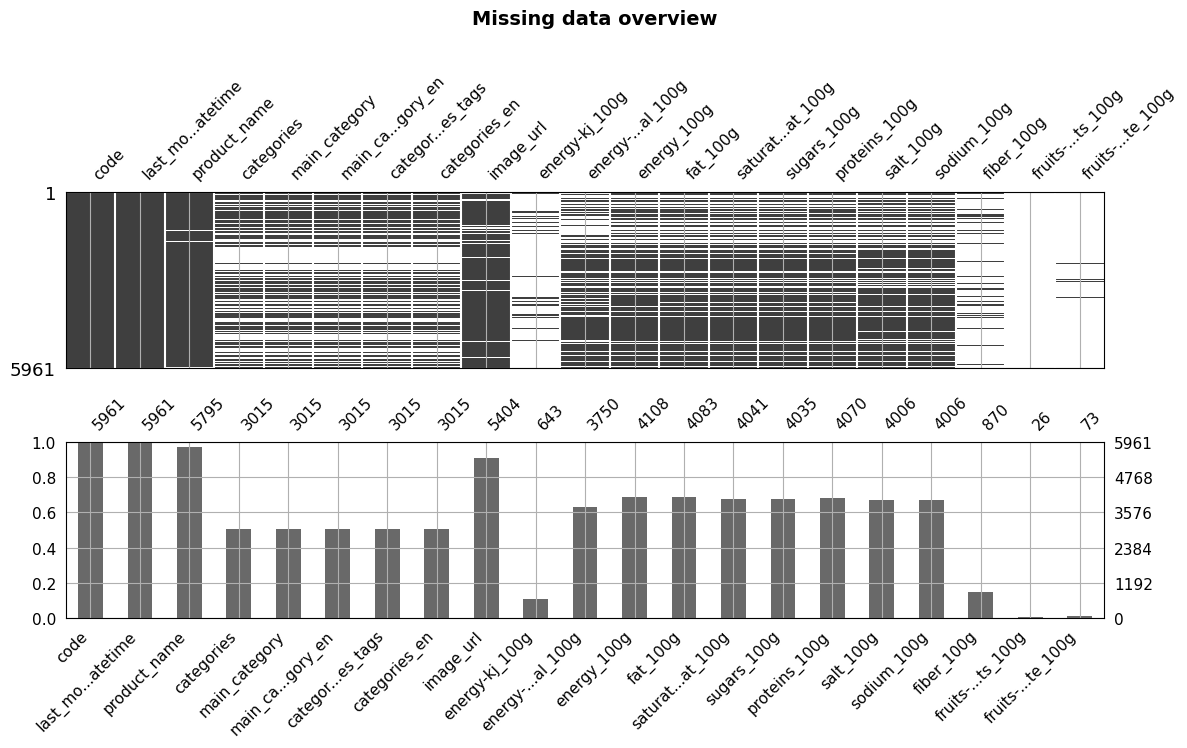

In [36]:
plot_missing_values(df_temp, 30)

<div class="alert alert-block alert-warning">
<b>Analyzing products without a barcode</b><br>
After analyzing the products without barcode in Open Food Facts, we have decided to <b>delete them</b> after making the <b>NaN imputation</b>,<br> because these records <b>cannot be found</b> at the time of a product <b>search by a user</b>.    
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.2. Processing the non-uniques codes</h3>
</div>

<div class="alert alert-block alert-warning">
    Based on the function <b>df_analysis</b> result, we can see that there are some codes which are not unique so, it is necessary to work on them</br></br>
   
To do this, we are going to make the following steps:
<ul style="list-style-type: square;">
    <li>Filter the dataset by non-unique <b>code</b></li>
    <li>Select most recent value based on year for each code considering the multiples columns</li>
    <li>Merge the dataset with the filtered information</li>
</ul>
</div>

In [37]:
df_temp = df_nutri_score[df_nutri_score.duplicated(subset=["code"], keep=False)].copy()
df_temp = df_temp.sort_values(["code", "last_modified_datetime"], ascending=True)

In [38]:
df_temp.head(5)

,code,last_modified_datetime,product_name,categories,main_category,main_category_en,categories_tags,categories_en,image_url,energy-kj_100g,...,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fiber_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g
577581,246804,2019-06-01 09:59:11,"Salade Chou, Pomme, céleri",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,611.0,10.400000,1.2,10.400000,1.5,0.30,0.120,NaN,NaN,NaN
48759,246804,2020-12-10 19:57:25,"Salade chou,pomme,céleri","Plats préparés, Salades, Salades composées, Sa...",en:vegetable-salads,Vegetable salads,"en:meals,en:salads,en:prepared-salads,en:veget...","Meals,Salads,Prepared salads,Vegetable salads",https://static.openfoodfacts.org/images/produc...,NaN,...,611.0,10.400000,1.2,10.400000,1.5,0.25,0.100,2.3,NaN,NaN
662890,315739,2019-07-23 18:22:59,Sandwich Jambon Fromage Sans Gluten,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1063.0,12.700000,5.5,2.500000,10.7,1.20,0.480,NaN,NaN,NaN
63896,315739,2019-12-02 14:52:43,NaN,"Sandwichs, Sandwichs garnis de charcuteries, S...",en:ham-and-cheese-sandwiches,Ham and cheese sandwiches,"en:sandwiches,en:sandwiches-filled-with-cold-c...","Sandwiches,Sandwiches filled with cold cuts,Ch...",https://static.openfoodfacts.org/images/produc...,1060.0,...,1060.0,12.700000,5.5,2.500000,10.7,1.30,0.520,3.8,NaN,NaN
780012,331470,2019-07-23 10:57:35,4 Gluten Free zesty lemon muffins,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1703.0,17.799999,2.7,33.599998,4.0,0.33,0.132,NaN,NaN,NaN


In [39]:
# df_temp["code"] = df_temp["code"].astype(str)

In [40]:
df_temp = pd.DataFrame(df_temp).reset_index()

In [41]:
del df_temp["index"]
df_temp.head(5)

,code,last_modified_datetime,product_name,categories,main_category,main_category_en,categories_tags,categories_en,image_url,energy-kj_100g,...,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fiber_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g
0,246804,2019-06-01 09:59:11,"Salade Chou, Pomme, céleri",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,611.0,10.400000,1.2,10.400000,1.5,0.30,0.120,NaN,NaN,NaN
1,246804,2020-12-10 19:57:25,"Salade chou,pomme,céleri","Plats préparés, Salades, Salades composées, Sa...",en:vegetable-salads,Vegetable salads,"en:meals,en:salads,en:prepared-salads,en:veget...","Meals,Salads,Prepared salads,Vegetable salads",https://static.openfoodfacts.org/images/produc...,NaN,...,611.0,10.400000,1.2,10.400000,1.5,0.25,0.100,2.3,NaN,NaN
2,315739,2019-07-23 18:22:59,Sandwich Jambon Fromage Sans Gluten,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1063.0,12.700000,5.5,2.500000,10.7,1.20,0.480,NaN,NaN,NaN
3,315739,2019-12-02 14:52:43,NaN,"Sandwichs, Sandwichs garnis de charcuteries, S...",en:ham-and-cheese-sandwiches,Ham and cheese sandwiches,"en:sandwiches,en:sandwiches-filled-with-cold-c...","Sandwiches,Sandwiches filled with cold cuts,Ch...",https://static.openfoodfacts.org/images/produc...,1060.0,...,1060.0,12.700000,5.5,2.500000,10.7,1.30,0.520,3.8,NaN,NaN
4,331470,2019-07-23 10:57:35,4 Gluten Free zesty lemon muffins,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1703.0,17.799999,2.7,33.599998,4.0,0.33,0.132,NaN,NaN,NaN


In [42]:
df_temp = df_temp.rename_axis(None, axis=1)

In [43]:
df_temp.head(5)

,code,last_modified_datetime,product_name,categories,main_category,main_category_en,categories_tags,categories_en,image_url,energy-kj_100g,...,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fiber_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g
0,246804,2019-06-01 09:59:11,"Salade Chou, Pomme, céleri",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,611.0,10.400000,1.2,10.400000,1.5,0.30,0.120,NaN,NaN,NaN
1,246804,2020-12-10 19:57:25,"Salade chou,pomme,céleri","Plats préparés, Salades, Salades composées, Sa...",en:vegetable-salads,Vegetable salads,"en:meals,en:salads,en:prepared-salads,en:veget...","Meals,Salads,Prepared salads,Vegetable salads",https://static.openfoodfacts.org/images/produc...,NaN,...,611.0,10.400000,1.2,10.400000,1.5,0.25,0.100,2.3,NaN,NaN
2,315739,2019-07-23 18:22:59,Sandwich Jambon Fromage Sans Gluten,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1063.0,12.700000,5.5,2.500000,10.7,1.20,0.480,NaN,NaN,NaN
3,315739,2019-12-02 14:52:43,NaN,"Sandwichs, Sandwichs garnis de charcuteries, S...",en:ham-and-cheese-sandwiches,Ham and cheese sandwiches,"en:sandwiches,en:sandwiches-filled-with-cold-c...","Sandwiches,Sandwiches filled with cold cuts,Ch...",https://static.openfoodfacts.org/images/produc...,1060.0,...,1060.0,12.700000,5.5,2.500000,10.7,1.30,0.520,3.8,NaN,NaN
4,331470,2019-07-23 10:57:35,4 Gluten Free zesty lemon muffins,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1703.0,17.799999,2.7,33.599998,4.0,0.33,0.132,NaN,NaN,NaN


<div class="alert alert-block alert-info">
    Select most recent value based on year for each code considering the multiples columns
</div>

In [44]:
df_temp = df_temp.groupby("code", as_index=False).last()

In [45]:
df_temp.head(6)

,code,last_modified_datetime,product_name,categories,main_category,main_category_en,categories_tags,categories_en,image_url,energy-kj_100g,...,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fiber_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g
0,246804,2020-12-10 19:57:25,"Salade chou,pomme,céleri","Plats préparés, Salades, Salades composées, Sa...",en:vegetable-salads,Vegetable salads,"en:meals,en:salads,en:prepared-salads,en:veget...","Meals,Salads,Prepared salads,Vegetable salads",https://static.openfoodfacts.org/images/produc...,NaN,...,611.0,10.400000,1.200000,10.400000,1.5,0.25,0.100,2.3,NaN,NaN
1,315739,2019-12-02 14:52:43,Sandwich Jambon Fromage Sans Gluten,"Sandwichs, Sandwichs garnis de charcuteries, S...",en:ham-and-cheese-sandwiches,Ham and cheese sandwiches,"en:sandwiches,en:sandwiches-filled-with-cold-c...","Sandwiches,Sandwiches filled with cold cuts,Ch...",https://static.openfoodfacts.org/images/produc...,1060.0,...,1060.0,12.700000,5.500000,2.500000,10.7,1.30,0.520,3.8,NaN,NaN
2,331470,2021-04-01 13:41:55,Muffins au citron,"Biscuits et gâteaux, Gâteaux, Muffins, Muffins...",fr:muffins-au-citron,fr:muffins-au-citron,"en:biscuits-and-cakes,en:cakes,en:muffins,en:f...","Biscuits and cakes,Cakes,Muffins,Fruit Muffins...",https://static.openfoodfacts.org/images/produc...,NaN,...,1703.0,17.799999,2.700000,33.599998,4.0,0.33,0.132,NaN,NaN,NaN
3,333214,2019-07-31 12:37:28,Belgium milk chocolate coated toffee popcorn,"Produits de la mer, Produits à tartiner, Produ...",en:taramasalata,Taramasalata,"en:seafood,en:spreads,en:salted-spreads,en:tar...","Seafood,Spreads,Salted spreads,Taramasalata",None,NaN,...,2197.0,28.200001,16.700001,48.299999,6.1,1.05,0.420,0.0,NaN,NaN
4,352536,2019-09-15 14:15:32,Fab Flamingo,NaN,NaN,NaN,NaN,NaN,https://static.openfoodfacts.org/images/produc...,NaN,...,1477.0,1.300000,0.900000,54.299999,0.3,0.55,0.220,NaN,NaN,NaN
5,360616,2020-01-13 16:40:52,Green Thai curry & jasmin rice,NaN,NaN,NaN,NaN,NaN,https://static.openfoodfacts.org/images/produc...,NaN,...,623.0,6.200000,2.800000,2.600000,3.6,0.40,0.160,NaN,NaN,NaN


<div class="alert alert-block alert-info">
    Deleting the non-unique values from <b>Nutri-Score</b> dataset
</div>

In [46]:
df_temp.shape

(60, 21)

In [47]:
df_nutri_score.shape

(798009, 21)

In [48]:
df_nutri_score = df_nutri_score[~df_nutri_score["code"].isin(df_temp["code"])]

In [49]:
df_nutri_score.shape

(797889, 21)

<div class="alert alert-block alert-info">
    Concatenating the datasets to have <b>only unique</b> values by <b>code</b>
</div>

In [50]:
df_nutri_score = pd.concat([df_nutri_score, df_temp])

In [51]:
df_nutri_score.shape

(797949, 21)

In [52]:
df_analysis(df_nutri_score, "df_nutri_score", "code", flag="complete")


Analysis of df_nutri_score dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 21 columns
- Total of NaN values:            6739447
- Percentage of NaN:              40.22 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                        ( memory usage: 89.3+ MB )
---------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,797949,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,last_modified_datetime,datetime64[ns],797949,696938,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_name,object,774969,528723,22980,2.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,image_url,object,720220,720152,77729,9.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,energy_100g,float32,623047,4545,174902,21.92,1178.401978,0.0,464.000,1100.000000,1674.000000,12200000.0,15539.136719
13,saturated-fat_100g,float32,620031,3684,177918,22.30,5.447080,0.0,0.200,2.000000,8.000000,21900.0,29.067114
14,sugars_100g,float32,619296,5341,178653,22.39,13.760906,-1.0,0.600,3.500000,19.950001,6880.0,21.926207
15,proteins_100g,float32,618950,4101,178999,22.43,9.138597,0.0,1.500,6.200000,12.900000,173000.0,220.109772
12,fat_100g,float32,617071,4941,180878,22.67,14.309892,0.0,1.000,8.000000,22.000000,91200.0,117.427109
16,salt_100g,float32,603523,6284,194426,24.37,1.310912,0.0,0.060,0.510000,1.300000,25000.0,32.951717


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.3. Analyzing the missing values in Energy field</h3>
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Nutri-score field</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
 	<tr>
		<td align="left">Energetic value</td>
		<td align="center">Yes</td>
        <td align="left">
            energy-kj_100g<br>
            energy-kcal_100g<br>
            energy_100g</td>
        <td align="left">
            The fields energy-kj_100g and energy_100g seem to be the same value.<br>
            Consider the measure units to work with the values.
        </td>
 	</tr>
</table>

In [53]:
df_analysis(df_nutri_score[["code", "energy_100g", "energy-kcal_100g", "energy-kj_100g"]], "df_nutri_score", "code", flag="complete")


Analysis of df_nutri_score dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 4 columns
- Total of NaN values:            1103419
- Percentage of NaN:              34.57 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                        ( memory usage: 21.3+ MB )
---------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,797949,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,energy_100g,float32,623047,4545,174902,21.92,1178.401978,0.0,464.0,1100.0,1674.0,12200000.0,15539.136719
2,energy-kcal_100g,float32,595481,5536,202468,25.37,283.296692,0.0,111.0,265.0,402.0,2910000.0,3785.686768
3,energy-kj_100g,float32,71900,3608,726049,90.99,1103.704102,0.0,435.0,977.0,1610.0,1094259.0,4161.389160


<div style="color: RGB(255,114,0);">
Some products selected from the website to analyze their data / columns
</div>

In [54]:
VALUES_TEMP = [
    "3017620422003", "3033710065967", "3229820100234"
]

In [55]:
df_nutri_score[df_nutri_score["code"].isin(VALUES_TEMP)]

,code,last_modified_datetime,product_name,categories,main_category,main_category_en,categories_tags,categories_en,image_url,energy-kj_100g,...,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fiber_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g
629040,3017620422003,2021-04-24 16:51:44,Nutella,"Produits à tartiner,Petit-déjeuners,Aides culi...",en:sugary-cooking-helpers,Sugary cooking helpers,"en:spreads,en:breakfasts,en:cooking-helpers,en...","Spreads,Breakfasts,Cooking helpers,Sweet sprea...",https://static.openfoodfacts.org/images/produc...,2252.0,...,2252.0,30.9,10.6,56.299999,6.3,0.107,0.0428,NaN,NaN,NaN
637275,3033710065967,2021-03-02 09:38:08,Nesquik,"Boissons, Petit-déjeuners, Cacaos et chocolats...",en:chocolate-powders,Chocolate powders,"en:beverages,en:breakfasts,en:cocoa-and-its-pr...","Beverages,Breakfasts,Cocoa and its products,Co...",https://static.openfoodfacts.org/images/produc...,1591.0,...,1591.0,3.0,1.5,75.000000,5.0,0.400,0.1600,6.5,NaN,NaN
688799,3229820100234,2021-03-27 15:25:14,Fourrés Chocolat noir,"Snacks, Snacks sucrés, Biscuits et gâteaux, Bi...",fr:biscuits-fourres-chocolat,fr:biscuits-fourres-chocolat,"en:snacks,en:sweet-snacks,en:biscuits-and-cake...","Snacks,Sweet snacks,Biscuits and cakes,Biscuit...",https://static.openfoodfacts.org/images/produc...,2004.0,...,2004.0,20.0,7.0,27.000000,7.1,0.500,0.2000,4.8,NaN,NaN


<div class="alert alert-block alert-info">
The <b>energy_100g</b> and <b>energy-kj_100g</b> fields are the same but it is necessary to compare in details these columns</br>
Let's compare the fields considering the <b>energy-kj_100g</b> as main field because it has <b>fewer data</b> than The <b>energy_100g</b> field
<ul style="list-style-type: square;">
    <li><b>energy_100g</b> has 623047 values</li>
    <li><b>energy-kj_100g</b> has 71900 values</li>
</ul>
</div>

In [56]:
df_temp = df_nutri_score[df_nutri_score["energy-kj_100g"].notnull()]

In [57]:
df_temp = pd.DataFrame(df_temp[["code", "energy_100g", "energy-kj_100g"]])

<div class="alert alert-block alert-info">
Now, let's compare <b>energy_100g</b> with <b>energy-kcal_100g</b> 
</div>

In [58]:
df_temp["comparison_column"] = np.where(df_temp["energy_100g"] == df_temp["energy-kj_100g"], True, False)

In [59]:
print("Amount of rows with differentes data between \"energy_100g\" and \"energy-kj_100g\" is:",
        df_temp[df_temp["comparison_column"] == False].shape[0]
)

Amount of rows with differentes data between "energy_100g" and "energy-kj_100g" is: 4


<div class="alert alert-block alert-success">
At this point, we got that there are only 4 rows with different data between <b>energy_100g</b> and <b>energy-kj_100g</b> fields so,</br> we can proceed to delete the <b>energy-kj_100g</b> field because the error could be minimum
</div>

In [60]:
del df_nutri_score["energy-kj_100g"]

In [61]:
df_analysis(df_nutri_score[["code", "energy_100g", "energy-kcal_100g"]], "df_nutri_score", "code", flag="complete")


Analysis of df_nutri_score dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 3 columns
- Total of NaN values:            377370
- Percentage of NaN:              15.76 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                        ( memory usage: 18.3+ MB )
---------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,797949,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,energy_100g,float32,623047,4545,174902,21.92,1178.401978,0.0,464.0,1100.0,1674.0,12200000.0,15539.136719
2,energy-kcal_100g,float32,595481,5536,202468,25.37,283.296692,0.0,111.0,265.0,402.0,2910000.0,3785.686768


<div style="color: RGB(255,114,0);">
Some products selected from the website to analyze their data / columns
</div>

In [62]:
VALUES_TEMP = [
    "3017620422003", "3033710065967", "3229820100234"
]

In [63]:
df_nutri_score[df_nutri_score["code"].isin(VALUES_TEMP)]

,code,last_modified_datetime,product_name,categories,main_category,main_category_en,categories_tags,categories_en,image_url,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fiber_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g
629040,3017620422003,2021-04-24 16:51:44,Nutella,"Produits à tartiner,Petit-déjeuners,Aides culi...",en:sugary-cooking-helpers,Sugary cooking helpers,"en:spreads,en:breakfasts,en:cooking-helpers,en...","Spreads,Breakfasts,Cooking helpers,Sweet sprea...",https://static.openfoodfacts.org/images/produc...,539.0,2252.0,30.9,10.6,56.299999,6.3,0.107,0.0428,NaN,NaN,NaN
637275,3033710065967,2021-03-02 09:38:08,Nesquik,"Boissons, Petit-déjeuners, Cacaos et chocolats...",en:chocolate-powders,Chocolate powders,"en:beverages,en:breakfasts,en:cocoa-and-its-pr...","Beverages,Breakfasts,Cocoa and its products,Co...",https://static.openfoodfacts.org/images/produc...,376.0,1591.0,3.0,1.5,75.000000,5.0,0.400,0.1600,6.5,NaN,NaN
688799,3229820100234,2021-03-27 15:25:14,Fourrés Chocolat noir,"Snacks, Snacks sucrés, Biscuits et gâteaux, Bi...",fr:biscuits-fourres-chocolat,fr:biscuits-fourres-chocolat,"en:snacks,en:sweet-snacks,en:biscuits-and-cake...","Snacks,Sweet snacks,Biscuits and cakes,Biscuit...",https://static.openfoodfacts.org/images/produc...,478.0,2004.0,20.0,7.0,27.000000,7.1,0.500,0.2000,4.8,NaN,NaN


<div class="alert alert-block alert-info">
As you know, at this point we have deleted <b>energy-kj_100g</b> field beacuse it is the same as <b>energy_100g</b><br><br>

On the other hand, we know the following:
<ul style="list-style-type: square;">
    <li>1 kcal = 4,1868 kJ</li>
    <li>1 kJ = 0,2388 kcal</li>
</ul>

So, we can try to complete the <b>energy_100g</b> field with values of <b>energy-kcal_100g</b> field after the respective unit of measure conversion
    
First of all, let's check whether there is some <b>energy_100g</b> values that we can complete with <b>energy-kj_100g</b> values
</div>

In [64]:
print("Amount of \"energy_100g\" to complete with \"energy-kcal_100g\" is:",
        df_nutri_score[(df_nutri_score["energy_100g"].isna()) & (df_nutri_score["energy-kcal_100g"].notnull())].shape[0]
)

Amount of "energy_100g" to complete with "energy-kcal_100g" is: 0


<div class="alert alert-block alert-success">
    There is not some <b>energy_100g</b> values that we can complete with <b>energy-kcal_100g</b> values so,</br> we can proceed to delete the <b>energy-kcal_100g</b> field
</div>

In [65]:
del df_nutri_score["energy-kcal_100g"]

In [66]:
df_analysis(df_nutri_score, "df_nutri_score", "code", flag="complete")


Analysis of df_nutri_score dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 19 columns
- Total of NaN values:            5810930
- Percentage of NaN:              38.33 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                        ( memory usage: 83.2+ MB )
---------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,797949,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,last_modified_datetime,datetime64[ns],797949,696938,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_name,object,774969,528723,22980,2.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,image_url,object,720220,720152,77729,9.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,energy_100g,float32,623047,4545,174902,21.92,1178.401978,0.0,464.000,1100.000000,1674.000000,12200000.0,15539.136719
11,saturated-fat_100g,float32,620031,3684,177918,22.30,5.447080,0.0,0.200,2.000000,8.000000,21900.0,29.067114
12,sugars_100g,float32,619296,5341,178653,22.39,13.760906,-1.0,0.600,3.500000,19.950001,6880.0,21.926207
13,proteins_100g,float32,618950,4101,178999,22.43,9.138597,0.0,1.500,6.200000,12.900000,173000.0,220.109772
10,fat_100g,float32,617071,4941,180878,22.67,14.309892,0.0,1.000,8.000000,22.000000,91200.0,117.427109
14,salt_100g,float32,603523,6284,194426,24.37,1.310912,0.0,0.060,0.510000,1.300000,25000.0,32.951717


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.4. Analyzing the missing values in Salt / Sodium</h3>
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Nutri-score field</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
  	<tr>
		<td align="left">Salt / Sodium</td>
		<td align="center">Yes</td>
        <td align="left">
            salt_100g<br>
            sodium_100g</td>
        <td align="left">Consider the measure units to work with the values.</td>
 	</tr>
</table>

In [67]:
df_analysis(df_nutri_score[["code", "salt_100g", "sodium_100g"]], "df_nutri_score", "code", flag="complete")


Analysis of df_nutri_score dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 3 columns
- Total of NaN values:            388853
- Percentage of NaN:              16.24 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                        ( memory usage: 18.3+ MB )
---------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,797949,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,salt_100g,float32,603523,6284,194426,24.37,1.310912,0.0,0.060,0.510,1.30,25000.0,32.951717
2,sodium_100g,float32,603522,6681,194427,24.37,0.524468,0.0,0.024,0.204,0.52,10000.0,13.180746


In [68]:
print("Amount of \"salt_100g\" to complete with \"energy-sodium_100g\" is:",
        df_nutri_score[(df_nutri_score["salt_100g"].isna()) & (df_nutri_score["sodium_100g"].notnull())].shape[0]
)

Amount of "salt_100g" to complete with "energy-sodium_100g" is: 0


<div class="alert alert-block alert-success">
    Based on <b>df_analysis</b>, we can see that <b>salt_100g</b> and <b>sodium_100g</b> have the same amount of data so,<br>
    we can proceed to delete one of them. In this case, we are going to delete <b>sodium_100g</b>
</div>

In [69]:
del df_nutri_score["sodium_100g"]

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.5. Analyzing the missing values in Fruits, vegetables, legumes,nuts, rapeseed, walnut and olive oils</h3>
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Nutri-score field</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
  	<tr>
		<td align="left">
            Fruits, vegetables, legumes,<br>
            nuts, rapeseed, walnut<br> and olive oils
        </td>
		<td align="center">Yes</td>
        <td align="left">
            fruits-vegetables-nuts_100g<br>
            fruits-vegetables-nuts-estimate_100g
        </td>
        <td align="left">
            It is necessary to analyze these fields more in details. 
        </td>
 	</tr>
</table>

In [70]:
VALUES_TEMP = [
    "code", "fruits-vegetables-nuts_100g", "fruits-vegetables-nuts-estimate_100g"
]

In [71]:
df_analysis(df_nutri_score[VALUES_TEMP], "df_nutri_score", "code", flag="complete")


Analysis of df_nutri_score dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 3 columns
- Total of NaN values:            1579110
- Percentage of NaN:              65.97 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                        ( memory usage: 18.3+ MB )
---------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,797949,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,fruits-vegetables-nuts-estimate_100g,float32,10488,824,787461,98.69,46.186382,0.0,17.00,50.000000,64.0,100.0,28.991516
1,fruits-vegetables-nuts_100g,float32,6300,1086,791649,99.21,39.357761,0.0,4.09,30.630001,65.0,100.0,36.253693


In [72]:
df_temp = df_nutri_score[["code", "fruits-vegetables-nuts_100g", "fruits-vegetables-nuts-estimate_100g"]]

<div style="color: RGB(255,114,0);">
Some products selected from the website to analyze their data / columns
</div>

In [73]:
VALUES_TEMP = [
    "8076809513722", "8076809545396", "8076809513388"
]

In [74]:
df_nutri_score[df_nutri_score["code"].isin(VALUES_TEMP)]

,code,last_modified_datetime,product_name,categories,main_category,main_category_en,categories_tags,categories_en,image_url,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,fiber_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g
1508404,8076809513388,2021-04-24 19:37:58,Barilla sauce tomates arrabbiata,"Epicerie, Sauces, Sauces pour pâtes, Sauces to...",en:pimented-tomato-sauces,Pimented tomato sauces,"en:groceries,en:sauces,en:pasta-sauces,en:toma...","Groceries,Sauces,Pasta sauces,Tomato sauces,Ar...",https://static.openfoodfacts.org/images/produc...,250.0,3.1,0.3,5.0,1.4,1.00,2.2,90.000000,89.000000
1508415,8076809513722,2021-04-03 06:43:34,Barilla sauce tomates basilic,"Epicerie, Sauces, Sauces tomate, Sauces tomate...",en:food,Food,"en:groceries,en:sauces,en:tomato-sauces,en:tom...","Groceries,Sauces,Tomato sauces,Tomato sauces w...",https://static.openfoodfacts.org/images/produc...,268.0,2.6,0.3,5.9,1.6,0.90,1.9,88.000000,86.800003
1508755,8076809545396,2021-04-22 04:30:14,Pesti con Basilico e Rucola,"Lebensmittel, Saucen, Nudelsoßen, Pestos, Pest...",en:green-pestos,Green pestos,"en:groceries,en:sauces,en:pasta-sauces,en:pest...","Groceries,Sauces,Pasta sauces,Pestos,Green pestos",https://static.openfoodfacts.org/images/produc...,1828.0,42.5,5.0,5.0,3.9,1.24,2.0,35.400002,NaN


<div class="alert alert-block alert-info">
    Based on the function <b>df_analysis</b> we can see that there are almost 100% of missing-values for the three columns.<br><br>
    At the same time and based on <b>https://fr.openfoodfacts.org/</b> who says that the field <b>fruits-vegetables-nuts-estimate_100g</b> is a manual estimation<br> with the list of ingredients so, we can say that the most important field is <b>fruits-vegetables-nuts_100g</b>.<br><br>
    Due to that, we can try to complete the field <b>fruits-vegetables-nuts_100g</b> with values of <b>fruits-vegetables-nuts-estimate_100g</b>
</div>

In [75]:
print("Amount of \"fruits-vegetables-nuts_100g\" to complete with \"fruits-vegetables-nuts-estimate_100g\" is:",
        df_nutri_score[(df_nutri_score["fruits-vegetables-nuts_100g"].isna()) & (df_nutri_score["fruits-vegetables-nuts-estimate_100g"].notnull())].shape[0]
)

Amount of "fruits-vegetables-nuts_100g" to complete with "fruits-vegetables-nuts-estimate_100g" is: 10280


<div class="alert alert-block alert-info">
    The column <b>fruits-vegetables-nuts-estimate_100g</b> has 10280 records  that can use to complete the information in the column <b>fruits-vegetables-nuts_100g</b>.<br>
    So, let's try to use them. 
</div>

In [76]:
df_nutri_score["fruits-vegetables-nuts_100g"].fillna(df_nutri_score["fruits-vegetables-nuts-estimate_100g"], inplace=True)

In [77]:
print("Amount of \"fruits-vegetables-nuts_100g\" to complete with \"fruits-vegetables-nuts-estimate_100g\" is:",
        df_nutri_score[(df_nutri_score["fruits-vegetables-nuts_100g"].isna()) & (df_nutri_score["fruits-vegetables-nuts-estimate_100g"].notnull())].shape[0]
)

Amount of "fruits-vegetables-nuts_100g" to complete with "fruits-vegetables-nuts-estimate_100g" is: 0


In [78]:
VALUES_TEMP = [
    "code", "fruits-vegetables-nuts_100g", "fruits-vegetables-nuts-estimate_100g"
]

In [79]:
df_analysis(df_nutri_score[VALUES_TEMP], "df_nutri_score", "code", flag="complete")


Analysis of df_nutri_score dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 3 columns
- Total of NaN values:            1568830
- Percentage of NaN:              65.54 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                        ( memory usage: 18.3+ MB )
---------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,797949,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,fruits-vegetables-nuts_100g,float32,16580,1465,781369,97.92,43.616482,0.0,12.0,48.614998,64.099998,100.0,32.062748
2,fruits-vegetables-nuts-estimate_100g,float32,10488,824,787461,98.69,46.186382,0.0,17.0,50.000000,64.000000,100.0,28.991516


<div class="alert alert-block alert-success">
    At this point, we have completed the information with the data contains in both column.<br>
    Now, we can delete the columns <b>fruits-vegetables-nuts-estimate_100g</b>
</div>

In [80]:
del df_nutri_score["fruits-vegetables-nuts-estimate_100g"]

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.6. Analyzing the categories fields</h3>
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">App/Basic field</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
  	<tr>
		<td align="left">Category</td>
		<td align="center">No</td>
        <td align="left">
            categories<br>
            main_category<br>
            main_category_en<br>
            categories_tags<br>
            categories_en
        </td>
        <td align="left">
            It is necessary to analyze these fields more in details. 
        </td>
 	</tr>
</table>

In [81]:
VALUES_TEMP = [
    "code", "categories", "main_category", "main_category_en", "categories_tags", "categories_en"
]

In [82]:
df_analysis(df_nutri_score[VALUES_TEMP], "df_nutri_score", "code")


Analysis of df_nutri_score dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 6 columns
- Total of NaN values:            2192595
- Percentage of NaN:              45.8 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns   ( memory usage: 34.5+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,code,object,797949,0,0.00
1,categories,category,359430,438519,54.96
2,main_category,category,359430,438519,54.96
3,main_category_en,category,359430,438519,54.96
4,categories_tags,category,359430,438519,54.96
5,categories_en,category,359430,438519,54.96


In [83]:
VALUES_TEMP = [
    "8076809513722", "8076809545396", "8076809513388"
]

In [84]:
df_temp = pd.DataFrame(df_nutri_score[["code", "product_name", "categories", "main_category", "main_category_en", "categories_tags", "categories_en"]])

In [85]:
pd.set_option("max_colwidth", None)
df_temp[df_temp["code"].isin(VALUES_TEMP)]

,code,product_name,categories,main_category,main_category_en,categories_tags,categories_en
1508404,8076809513388,Barilla sauce tomates arrabbiata,"Epicerie, Sauces, Sauces pour pâtes, Sauces tomate, Sauces Arrabiata, Sauces tomates pimentées",en:pimented-tomato-sauces,Pimented tomato sauces,"en:groceries,en:sauces,en:pasta-sauces,en:tomato-sauces,en:arrabbiata-sauces,en:pimented-tomato-sauces","Groceries,Sauces,Pasta sauces,Tomato sauces,Arrabbiata sauces,Pimented tomato sauces"
1508415,8076809513722,Barilla sauce tomates basilic,"Epicerie, Sauces, Sauces tomate, Sauces tomates au basilic, en:food",en:food,Food,"en:groceries,en:sauces,en:tomato-sauces,en:tomato-sauces-with-basil,en:food","Groceries,Sauces,Tomato sauces,Tomato sauces with basil,Food"
1508755,8076809545396,Pesti con Basilico e Rucola,"Lebensmittel, Saucen, Nudelsoßen, Pestos, Pesto alla Genovese",en:green-pestos,Green pestos,"en:groceries,en:sauces,en:pasta-sauces,en:pestos,en:green-pestos","Groceries,Sauces,Pasta sauces,Pestos,Green pestos"


In [86]:
pd.reset_option("display.max_colwidth") # reset width of showing cols

<div class="alert alert-block alert-info">
    Comparing <b>main_category</b> against <b>main_category_en</b>
</div>

In [87]:
print("Amount of \"main_category\" to complete with \"main_category_en\" is:",
        df_temp[(df_temp["main_category"].isna()) & (df_nutri_score["main_category_en"].notnull())].shape[0]
)

Amount of "main_category" to complete with "main_category_en" is: 0


<div class="alert alert-block alert-info">
    Comparing <b>categories_en</b> against <b>categories_tags</b>
</div>

In [88]:
print("Amount of \"categories_en\" to complete with \"categories_tags\" is:",
        df_temp[(df_temp["categories_en"].isna()) & (df_nutri_score["categories_tags"].notnull())].shape[0]
)

Amount of "categories_en" to complete with "categories_tags" is: 0


<div class="alert alert-block alert-info">
    Comparing <b>categories</b> against <b>main_category_en</b>
</div>

In [89]:
print("Amount of \"c\" to complete with \"main_category_en\" is:",
        df_temp[(df_temp["categories"].isna()) & (df_nutri_score["main_category_en"].notnull())].shape[0]
)

Amount of "c" to complete with "main_category_en" is: 0


<div class="alert alert-block alert-info">
    Comparing <b>categories</b> against <b>categories_en</b>
</div>

In [90]:
print("Amount of \"categories\" to complete with \"categories_en\" is:",
        df_temp[(df_temp["categories"].isna()) & (df_nutri_score["categories_en"].notnull())].shape[0]
)

Amount of "categories" to complete with "categories_en" is: 0


<div class="alert alert-block alert-success">
    Based on <b>comparisons</b>, we can see that <b>categories</b> has the same amount of data that <b>categories_tags</b>, <b>main_category</b>, <b>main_category_en</b>, <b>categories_en</b> so,<br> we can proceed to delete all of them, except <b>categories</b>.
</div>

In [91]:
df_nutri_score.drop(["categories_tags", "main_category", "main_category_en"], axis=1, inplace=True)

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">6. Treating Nutri-Score missing-values</h2>
</div>

<div class="alert alert-block alert-info">
    After analyzing <b>df_nutri_score</b> columns, we got the table below (dataframe) to work on it.<br>
    Now, it is time to <b>treat</b> with <b>missing values</b> in our dataset
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Field</th>
        <th style="font-weight: bold;">Description</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
 	</tr>
 	<tr>
		<td align="left">Energetic value</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">energy_100g</td>
 	</tr>
 	<tr>
		<td align="left">Fat</td>
        <td align="center">Nutri-Score</td>
		<td align="center">No</td>
        <td align="left">fat_100g</td>
 	</tr>
 	<tr>
		<td align="left">Saturated fat</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">saturated-fat_100g</td>
 	</tr>
 	<tr>
		<td align="left">Sugar</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">sugars_100g</td>
 	</tr>
  	<tr>
		<td align="left">Protein</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">proteins_100g</td>
 	</tr>
  	<tr>
		<td align="left">Salt</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">salt_100g</td>
 	</tr>
  	<tr>
		<td align="left">Fibers</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">fiber_100g</td>
 	</tr>
  	<tr>
		<td align="left">
            Fruits, vegetables, legumes, nuts,<br>
            rapeseed, walnut and olive oils
        </td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">fruits-vegetables-nuts_100g</td>
 	</tr>
  	<tr>
		<td align="left">Code</td>
        <td align="center">App/Basic field</td>
		<td align="center">Yes</td>
        <td align="left">code</td>
 	</tr>
    <tr>
		<td align="left">Last modified</td>
        <td align="center">App/Basic field</td>
		<td align="center">Yes</td>
        <td align="left">last_modified_datetime</td>
 	</tr>
    <tr>
		<td align="left">Product name</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">product_name</td>
 	</tr>
    <tr>
		<td align="left">Category</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">categories</td>
 	</tr>
    <tr>
		<td align="left">Image</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">image_url</td>
 	</tr>
</table>

<div class="alert alert-block alert-warning">
    Based on the function <b>df_analysis</b> we got the following facts:
    
    <ul style="list-style-type: square;">
        <li>there are almost <b>32%</b> of <b>missing values</b> in the <b>dataset</b></li>
        <li>Most of <b>columns</b> are above <b>20%</b> of <b>missing values</b></li>
        <li>there are <b>two columns</b> above <b>80%</b> of <b>missing values</b></li>
    </ul>
</div>

In [92]:
df_analysis(df_nutri_score, "df_nutri_score", "code", flag="complete")


Analysis of df_nutri_score dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 14 columns
- Total of NaN values:            3503205
- Percentage of NaN:              31.36 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                        ( memory usage: 66.1+ MB )
---------------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,797949,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,last_modified_datetime,datetime64[ns],797949,696938,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_name,object,774969,528723,22980,2.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,image_url,object,720220,720152,77729,9.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,energy_100g,float32,623047,4545,174902,21.92,1178.401978,0.0,464.00,1100.000000,1674.000000,12200000.0,15539.136719
8,saturated-fat_100g,float32,620031,3684,177918,22.30,5.447080,0.0,0.20,2.000000,8.000000,21900.0,29.067114
9,sugars_100g,float32,619296,5341,178653,22.39,13.760906,-1.0,0.60,3.500000,19.950001,6880.0,21.926207
10,proteins_100g,float32,618950,4101,178999,22.43,9.138597,0.0,1.50,6.200000,12.900000,173000.0,220.109772
7,fat_100g,float32,617071,4941,180878,22.67,14.309892,0.0,1.00,8.000000,22.000000,91200.0,117.427109
11,salt_100g,float32,603523,6284,194426,24.37,1.310912,0.0,0.06,0.510000,1.300000,25000.0,32.951717


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.1. Deleting missing values based on hypothesis</h3>
</div>

<div class="alert alert-block alert-warning">
    <b>Hypothesis</b>
    <ul style="list-style-type: square;">
        <li>All <b>rows</b> that <b>only</b> have <b>"code"</b> and <b>"last modified"</b> value are going to be <b>deleted</b> as they are considered input <b>errors</b></li>
    </ul>
    
</div>

In [154]:
COLUMNS_TO_CHECK = [
    "product_name", "categories", "categories_en", "image_url", "energy_100g", "fat_100g", 
    "saturated-fat_100g", "sugars_100g", "proteins_100g", "salt_100g", "fiber_100g", 
    "fruits-vegetables-nuts_100g"
]

In [155]:
df_nutri_score.shape

(797949, 14)

In [156]:
df_nutri_score.dropna(subset=COLUMNS_TO_CHECK, how="all", inplace=True)

In [157]:
df_nutri_score.shape

(789823, 14)

<div class="alert alert-block alert-success">
    <b>8126 rows</b> were <b>deleted</b> based on the above hypothesis
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.1. Imputation by the mean</h3>
</div>

<div class="alert alert-block alert-danger">
<b>Flag position</b>
</div>

<div class="alert alert-block alert-danger">
<b>A considerar</b><br>
    - Valores aberrantes<br>
    - Histogramas
</div>

<div class="alert alert-block alert-warning">
<b>Analyzing products without a barcode</b><br>
After analyzing the products without barcode in Open Food Facts, we have decided to <b>delete them</b> after making the <b>NaN imputation</b>,<br> because these records <b>cannot be found</b> at the time of a product <b>search by a user</b>.    
</div>